# Bitcon Post Stamp Generator #
### -file for Fractal calculations- ###

JV - 2020

'Generates' Bitcoin address from latest transaction block verifies the balance of the Bitcoin  
Uses the HEX-value of the base58 adress to zoom & recenter the Manderbrot (5x 32-bits)  
Iterate :  
    {  
    1. Fractal image calcualtion by Numpy arrays (Nx x Nx array of floats)  
    2. Field of interest calculation by Numpy array : picks areas with most unique set of pixels  
    3.Calcualte zoom and re-center by Bitcoin Hex words  
    }  
Saved fractal file: fractal<nr>.png  
Add Stamp overlay, values and colors  
Save stamp file <btc58address>_stamp.png  

In [1]:
from datetime import datetime
import numba 
from numba import jit
import numpy as np

global IMAGENR
IMAGENR=0

In [2]:
# core fractal functions
@jit(nopython=True)
def iterate_mandelbrot(c, imax, z=0):
    for n in range(imax+1):
        z = z*z + c
        if abs(z) > 2:
            return n
    return None


def calculate_mandelbrot_image(N,i,c,s):
    f = np.array(np.zeros((N,N), dtype=np.complex))
    return calculate_mandelbrot_imager(N,i,c,s,f)

@jit()   
def calculate_mandelbrot_imager(res,itmax,ctr,scl,fractal):
    for i in range(0,res):
        for j in range(0,res):
            c = complex( (i-res/2)/scl+ctr[0], (j-res/2)/scl+ctr[1])
            n = iterate_mandelbrot(c,itmax)
            if n is None:
                fractal[i,j] = 1
            else:
                fractal[i,j] = n/itmax
    A = np.power(np.real(fractal),0.5)          
    return A


def calculate_foi(M): # split function to take out the temp array
    c = M[0][:].size
    r = M[:][0].size
    f = np.array(np.zeros(  (c,r)) )
    return calculate_foir(M,f)

@jit()    
def calculate_foir(M,foi):
    col = M[0][:].size
    rw = M[:][0].size
    for i in range(0,col):
        for j in range(0,rw):
             xs=i-2;xx=i+3                  # create dynamic array 5x5 
             if xs<0 : xs=0
             if xx>col : xx=col 
             ys=j-2;yy=j+3
             if ys<0 : ys=0
             if yy>rw : yy=rw
             cb = M[ys:yy,xs:xx]              # cube = matrix 5x5 = 25 points
             un = np.unique(cb); u = un.size  # number of calculate unique elements
             mn = np.mean(cb)                # summarize the elements  0.05 > 0.95
             if u>25/2 : foi[j,i] = mn     # write back interesting area parameter
             else : foi[j,i] = 0       
    return foi


def calculate_zoompoint(foi,centero,resolution, scale, slce) :
    foi_r = np.where(foi > np.max(foi)/3 ) # results in 2 1 dimensionla arrays  col:row
    #print ("input=",foi)
    s=np.array([0])
    if slce == 0 : s = np.random.uniform(0,foi_r[:][0].size,2)
    else : s[0]=  foi_r[:][0].size*slce
    xindex=foi_r[1][int(s[0])]
    yindex=foi_r[0][int(s[0])]
    centern= ( centero[0] + (yindex-resolution/2)/scale,  centero[1] + (xindex-resolution/2)/scale )
    return centern


def calculate_btcfractal(res,it_max,cntr,scl,btchex) :
    #dt = datetime.now()
    rs=res
    it= it_max
    sc=scl
    ct=cntr
    FRAC = calculate_mandelbrot_image(res,iterate_max,center,scale) # calculate mandelbrot
    for i in range(5,-1,-1): # iterations over BTC HEX
        FOI=calculate_foi(FRAC)
        ct = calculate_zoompoint(FOI,ct,rs,sc,int(btchex[i*8+2:i*8+10],16)/0xFFFFFFFF )
        sc = sc*25; it = int(it*1.19) # zoom in
        FRAC = calculate_mandelbrot_image(rs,it,ct,sc)
        #print_figure(FRAC,5,5,plt.cm.inferno)
    #dt = datetime.now()-dt
    #dt.microseconds/1000
    return FRAC,sc,it,ct

In [3]:
# define bitcoin web calls
import base58 as btc
import requests
import json

def get_btc_value(btc58) :
    rs="https://blockchain.info/rawaddr/"+btc58
    req = requests.get(rs); 
    if req.status_code==200 :
        a=req.json()
        b=a['final_balance']
    else: b=-1
    return b

def get_lastblock_btc() :
    bok=0
    while bok==0 :
        rs="https://blockchain.info/unconfirmed-transactions?format=json"
        req = requests.get(rs); resp= str(req.content)
        index = resp.find('addr'); 
        if resp[index+40] != '"' : bok=1
    b58=resp[index+7:index+41]
    bal=get_btc_value(b58)/100000000
    return b58,bal

In [4]:
#matplotlib and Piollow functions
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10

def print_figure(C,fname,a,b,cm) :
     global IMAGENR
     pylab.rcParams['figure.figsize'] = a,b
     fig = plt.figure()
     #ax = fig.add_subplot(111)
     plt.pcolor(np.abs(C),cmap=cm)
     #ax.set_aspect('equal')
     plt.axis('off')
     ipath= fname
     plt.savefig(ipath, dpi=1080/a) # graph part ends up at 800 pixels wide, as white border consumes 

def save_stamp(IM,imnr,btc,bal) :
    if bal >= 10000 : 
        B = int(round(bal/1000,0))
        fsize = 360
        unit =Image.open("Kbtc.png")
    else :
        if bal >= 1000 : 
            B = round(bal/100,0)/10
            fsize = 360
            unit =Image.open("Kbtc.png")   
            Cmap = plt.cm.viridis
        else :
            if  bal >= 10 :
                B = int(round(bal,0))
                fsize = 360
                unit =Image.open("btc.png") 
                Cmap = plt.cm.inferno
            else :
                if bal >= 1 :
                    B= round(bal*10,0)/10
                    fsize = 360
                    unit =Image.open("btc.png") 
                    Cmap = plt.cm.gist_heat
                else :
                    if bal >= 0.01 :
                        B = int(round(bal*1000,0))
                        fsize = 320
                        unit =Image.open("mbtc.png") 
                        Cmap = plt.cm.twilight_shifted
                    else : 
                        if bal >= 0.001 :
                            B = round(bal*10000,0)/10
                            fsize = 320
                            unit =Image.open("mbtc.png") 
                            Cmap = plt.cm.cubehelix
                        else :
                            if bal > 0.00001 :
                                B = int(round(bal*1000000,0))
                                fsize = 280
                                unit =Image.open("ubtc.png") 
                                Cmap = plt.cm.gnuplot
                            else : 
                                if bal > 0.00000001 :
                                    B = int(round(bal*100000000,0))
                                    fsize = 280
                                    unit =Image.open("satosh.png") 
                                    Cmap = plt.cm.PuOr
                                else :
                                    fsize = 280
                                    B=" ."
                                    unit =Image.open("btc.png") 
                                    Cmap = plt.cm.gray
    # print and save plot image with number                                    
    imname = "fractal"+ str(imnr) + ".png"
    print_figure(IM,imname,10,10,Cmap)
    #past stamp overlay on image
    img = Image.open(imname)
    background = Image.open("stamp.png")
    img.paste(background, (10, 1), background)    
    # past text on image
    topi = 145 +(360-fsize)*0.9
    img.paste(unit, (165, 145), unit)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("btc_black.ttf",fsize)
    draw.text((473, topi+3),str(B) ,(80,80,80),font)
    draw.text((470, topi),str(B) ,(230,230,230),font)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("btc_narrow.ttf", 150)
    draw.text((172, 652),btc[0:17],(80,80,80),font)
    draw.text((172, 792),btc[17:41],(80,80,80),font)
    draw.text((170, 650),btc[0:17],(230,230,230),font)
    draw.text((170, 790),btc[17:41],(230,230,230),font)
    #past stamp on postal-image
    post = Image.open("postal.png")
    img.paste(post, (800, 700), post)
    imname2= btc+"_stamp.png"
    return img.save(imname2)

## Start Conditions

In [11]:
Btc,Balance = get_lastblock_btc()
hex58 = btc.b58decode(Btc).hex()
print("Btc58,BtcHex,Balance ", Btc, hex58, Balance)

Btc58,BtcHex,Balance  3Cq8yQGQn8Yt5kPvZDJGLA3zUNAtF37omQ 057a32988395d562c3eaa764c90f8d84ec0e70151b591ec097 -1e-08


In [6]:
#Start Conditions
iterate_max = 256; center = (-0.25, 0); scale = 50; Nx = 128;   # start parameters for iteration max and centerpoint
F,scale,iterate_max,center = calculate_btcfractal(Nx,iterate_max,center,scale,hex58)


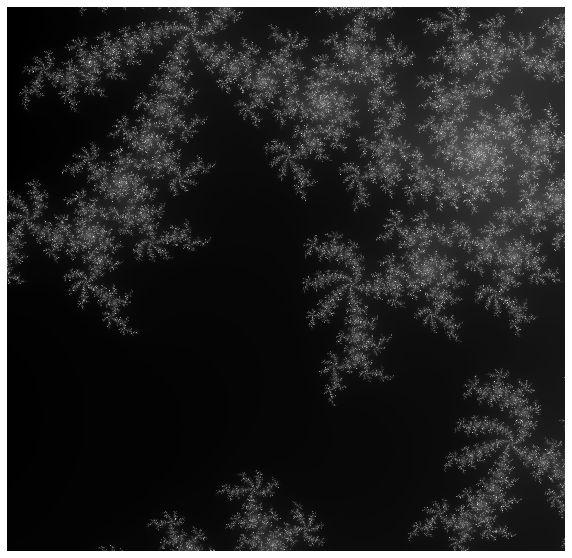

In [7]:
Nx=1080; scale = scale*4
F = calculate_mandelbrot_image(Nx,iterate_max,center,scale)
save_stamp(F,IMAGENR,Btc,Balance)
IMAGENR=IMAGENR+1

## EXTRA ##

In [509]:
print_figure(F,10,10,plt.cm.gist_heat)  # gist_heat / twilight_shifted / inferno / gnuplot / plasma / cubehelix             extreme : hsv /  gist_ncar / flag

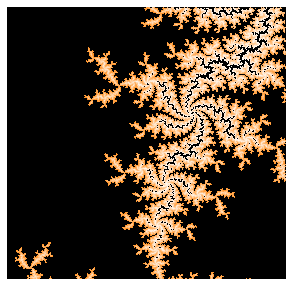

In [210]:
# extra function check :FOI
FOI=calculate_foi(F)           # make Field of Interest FOI plot
print_figure(FOI,"FOI.png",5,5,plt.cm.gist_heat)